In [35]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, precision_score, precision_recall_curve, PrecisionRecallDisplay

In [12]:
types = pd.read_csv("types.csv", sep=';')
codes = pd.read_csv("codes.csv", sep=';')
transactions = pd.read_csv("transactions.csv", sep=';')
train_set = pd.read_csv("train_set.csv", sep=';')
test_set = pd.read_csv("test_set.csv", sep=';')

In [13]:
'''
    Join `transactions` and `train_set` dataframes
'''
df = transactions.set_index("client_id").join(train_set.set_index("client_id")).reset_index().dropna()
df.head()

,client_id,datetime,code,type,sum,target
0,22899,231 09:31:53,6011,2110,-6737.75,1.0
1,22899,349 16:34:52,6011,4010,-8759.07,1.0
2,22899,441 15:36:37,6011,4010,-8759.07,1.0
3,22899,167 09:50:12,4814,1030,-1122.96,1.0
4,22899,221 18:54:19,5399,1110,-4626.59,1.0


In [14]:
'''
    Do time and day as different columns
    Add column weekday to analyze
    Add hours, minutes and seconds for time colunm
    Drop datetime, time client
'''
df[["day", "time"]] = df["datetime"].str.split(' ', 0, expand=True)
df[["hours", "minute", "seconds"]] = df["time"].str.split(':', 0, expand=True)
df.day = df.day.astype(int)
df.hours = df.hours.astype(int)
df.minute = df.minute.astype(int)
df.seconds = df.seconds.astype(int)
df.target = df.target.astype(int)
df["weekday"] = df.day % 7
df = df.drop(columns=["datetime", "time"])
print(df.dtypes)
df.head()

client_id      int64
code           int64
type           int64
sum          float64
target         int32
day            int32
hours          int32
minute         int32
seconds        int32
weekday        int32
dtype: object


,client_id,code,type,sum,target,day,hours,minute,seconds,weekday
0,22899,6011,2110,-6737.75,1,231,9,31,53,0
1,22899,6011,4010,-8759.07,1,349,16,34,52,6
2,22899,6011,4010,-8759.07,1,441,15,36,37,0
3,22899,4814,1030,-1122.96,1,167,9,50,12,6
4,22899,5399,1110,-4626.59,1,221,18,54,19,4


In [15]:
'''
    Split dataset to train and test sets
'''
from sklearn.model_selection import train_test_split
X = df.drop(columns=["target"])
y = df["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [16]:
'''
    Decision Tree Classifier
'''
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
cross_val_score(clf, X, y, cv=10)

array([0.51181531, 0.49014483, 0.51083524, 0.49308505, 0.38712839,
       0.44059675, 0.49183184, 0.60313657, 0.42256589, 0.49302984])

In [17]:
'''
    KNN
'''
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=3)
cross_val_score(clf, X, y, cv=10)

array([0.51159752, 0.4599804 , 0.49058042, 0.48840248, 0.35816182,
       0.42110421, 0.49194075, 0.60422566, 0.42256589, 0.49259421])

In [19]:
'''
    Random Forest Classifier
'''
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
cross_val_score(clf, X, y, cv=10)

array([0.51072634, 0.54176195, 0.54905804, 0.52324948, 0.40248285,
       0.4319939 , 0.49172294, 0.60466129, 0.45992159, 0.4924853 ])

In [26]:
'''
    Randomized Search CV
    
    Decision Tree Classifier
    Parameters:
        criterion: {“gini”, “entropy”}
        splitter: {“best”, “random”}
        max_depth: int
'''
param_dist = {
    "criterion": ["gini", "entropy"],
    "splitter": ["best", "random"],
    "max_depth": [1,2,3]
}
random_search = RandomizedSearchCV(DecisionTreeClassifier(), param_distributions=param_dist, n_iter=10)
random_search.fit(X_train, y_train)
random_search.best_params_

{'splitter': 'best', 'max_depth': 3, 'criterion': 'entropy'}

ROC/AUC: 0.5352500747819887
Precision: 0.5584437363743082


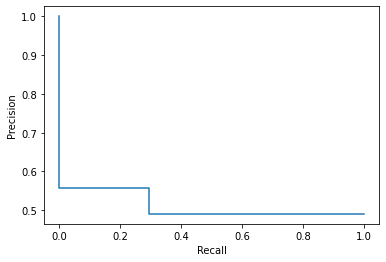

In [53]:
clf = DecisionTreeClassifier(splitter = 'best', max_depth = 3, criterion = 'entropy').fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("ROC/AUC:", roc_auc_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
precision, recall, _ = precision_recall_curve(y_test, y_pred)
PrecisionRecallDisplay(precision=precision, recall=recall).plot()

In [39]:
'''
    Randomized Search CV
    
    KNN
    Parameters:
        n_neighbors: int
        weights: {‘uniform’, ‘distance’} 
        algorithm: {‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}
'''
param_dist = {
    "n_neighbors": [1,2,3,4,5,6,7,8,9,10],
    "weights": ["uniform", "distance"],
    "algorithm": ["auto", "ball_tree", "kd_tree", "brute"]
}
random_search = RandomizedSearchCV(KNeighborsClassifier(), param_distributions=param_dist, n_iter=10)
random_search.fit(X_train, y_train)
random_search.best_params_

{'weights': 'uniform', 'n_neighbors': 1, 'algorithm': 'kd_tree'}

ROC/AUC: 0.9047760115627782
Precision: 0.9016016281744978


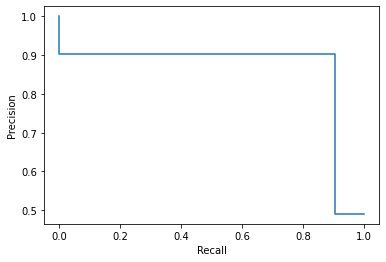

In [52]:
clf = KNeighborsClassifier(weights = 'uniform', n_neighbors = 1, algorithm = 'kd_tree').fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("ROC/AUC:", roc_auc_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
precision, recall, _ = precision_recall_curve(y_test, y_pred)
PrecisionRecallDisplay(precision=precision, recall=recall).plot()

In [45]:
'''
    Randomized Search CV
    
    Random Forest Classifier
    Parameters:
        n_estimators: int
        criterion: {“gini”, “entropy”}
'''
param_dist = {
    "n_estimators": [100, 200, 300, 400],
    "criterion": ["gini", "entropy"]
}
random_search = RandomizedSearchCV(RandomForestClassifier(), param_distributions=param_dist, n_iter=1)
random_search.fit(X_train, y_train)
random_search.best_params_

{'n_estimators': 200, 'criterion': 'entropy'}

ROC/AUC: 0.6528038268941558
Precision: 0.6650746268656716


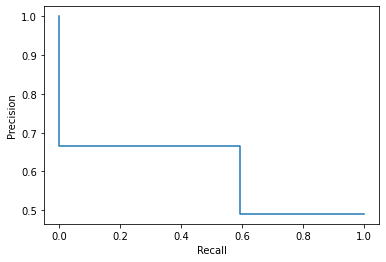

In [47]:
clf = RandomForestClassifier(n_estimators = 200, criterion = 'entropy').fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("ROC/AUC:", roc_auc_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
precision, recall, _ = precision_recall_curve(y_test, y_pred)
PrecisionRecallDisplay(precision=precision, recall=recall).plot()

In [49]:
'''
    Grid Search CV
    
    Decision Tree Classifier
    Parameters:
        criterion: {“gini”, “entropy”}
        splitter: {“best”, “random”}
        max_depth: int
'''
param_dist = {
    "criterion": ["gini", "entropy"],
    "splitter": ["best", "random"],
    "max_depth": [1,2,3]
}
grid_search = GridSearchCV(DecisionTreeClassifier(), param_dist)
grid_search.fit(X_train, y_train)
grid_search.best_params_

{'criterion': 'gini', 'max_depth': 3, 'splitter': 'best'}

ROC/AUC: 0.5374458385780188
Precision: 0.5643887362637363


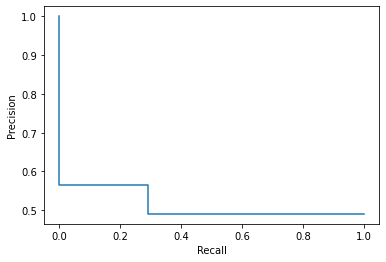

In [51]:
clf = DecisionTreeClassifier(splitter = 'best', max_depth = 3, criterion = 'gini').fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("ROC/AUC:", roc_auc_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
precision, recall, _ = precision_recall_curve(y_test, y_pred)
PrecisionRecallDisplay(precision=precision, recall=recall).plot()

In [56]:
'''
    Grid Search CV
    
    KNN
    Parameters:
        n_neighbors: int
        weights: {‘uniform’, ‘distance’} 
        algorithm: {‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}
'''
param_dist = {
    "n_neighbors": [1,2,3,4],
    "weights": ["uniform", "distance"],
    "algorithm": ["auto", "ball_tree", "kd_tree", "brute"]
}
grid_search = GridSearchCV(KNeighborsClassifier(), param_dist)
grid_search.fit(X_train, y_train)
grid_search.best_params_

{'algorithm': 'auto', 'n_neighbors': 1, 'weights': 'uniform'}

ROC/AUC: 0.9047760115627782
Precision: 0.9016016281744978


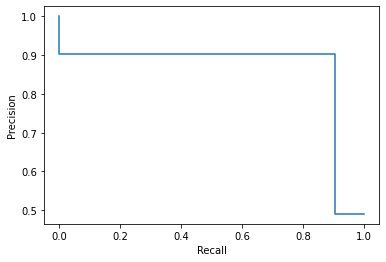

In [57]:
clf = KNeighborsClassifier(weights = 'uniform', n_neighbors = 1, algorithm = 'auto').fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("ROC/AUC:", roc_auc_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
precision, recall, _ = precision_recall_curve(y_test, y_pred)
PrecisionRecallDisplay(precision=precision, recall=recall).plot()

In [59]:
'''
    Grid Search CV
    
    Random Forest Classifier
    Parameters:
        n_estimators: int
        criterion: {“gini”, “entropy”}
'''
param_dist = {
    "n_estimators": [100, 200, 300, 400],
    "criterion": ["gini", "entropy"]
}
grid_search = GridSearchCV(RandomForestClassifier(), param_dist)
grid_search.fit(X_train, y_train)
grid_search.best_params_

{'n_estimators': 200, 'criterion': 'entropy'}

ROC/AUC: 0.6498734465075349
Precision: 0.6610505450941526


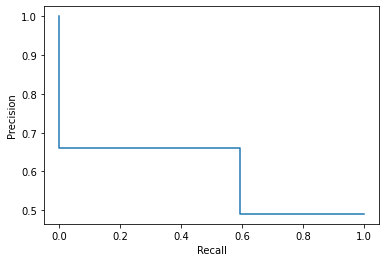

In [60]:
clf = RandomForestClassifier(n_estimators = 200, criterion = 'entropy').fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("ROC/AUC:", roc_auc_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
precision, recall, _ = precision_recall_curve(y_test, y_pred)
PrecisionRecallDisplay(precision=precision, recall=recall).plot()